# Analyse de Clustering et Réduction de Dimension


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')
import re

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 0. CHARGEMENT DES DONNÉES


In [2]:
file_path = 'poker_dataset.csv'
df = pd.read_csv(file_path)

print("=" * 60)
print("APERÇU DES DONNÉES")
print("=" * 60)
print(f"\nDimensions du dataset : {df.shape}")
print(f"\nPremières lignes :")
display(df.head())

print(f"\nInformations sur les colonnes :")
display(df.info())

print(f"\nStatistiques descriptives :")
display(df.describe())

print(f"\nValeurs manquantes :")
display(df.isnull().sum())

APERÇU DES DONNÉES

Dimensions du dataset : (1000000, 7)

Premières lignes :


,hand,flop,result1,turn,result2,river,result3
0,♣K ♥6,♦Q ♣3 ♥3,PAIR,♦Q ♣3 ♥3 ♣7,PAIR,♦Q ♣3 ♥3 ♣7 ♣6,TWO PAIR
1,♦4 ♦3,♥5 ♣2 ♥6,STRAIGHT,♥5 ♣2 ♥6 ♥A,STRAIGHT,♥5 ♣2 ♥6 ♥A ♠Q,STRAIGHT
2,♥7 ♣5,♥A ♣6 ♥5,PAIR,♥A ♣6 ♥5 ♣7,TWO PAIR,♥A ♣6 ♥5 ♣7 ♣4,TWO PAIR
3,♠2 ♣J,♥10 ♠A ♠9,NOTHING,♥10 ♠A ♠9 ♦4,NOTHING,♥10 ♠A ♠9 ♦4 ♦3,NOTHING
4,♠K ♥9,♥Q ♦K ♦A,PAIR,♥Q ♦K ♦A ♣8,PAIR,♥Q ♦K ♦A ♣8 ♦4,PAIR



Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   hand     1000000 non-null  object
 1   flop     1000000 non-null  object
 2   result1  1000000 non-null  object
 3   turn     1000000 non-null  object
 4   result2  1000000 non-null  object
 5   river    1000000 non-null  object
 6   result3  1000000 non-null  object
dtypes: object(7)
memory usage: 53.4+ MB


None


Statistiques descriptives :


,hand,flop,result1,turn,result2,river,result3
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,2652,132520,10,927129,10,998375,10
top,♠5 ♥8,♠4 ♠3 ♥4,NOTHING,♦A ♣7 ♦Q ♠7,PAIR,♦Q ♣6 ♣9 ♣5 ♥6,PAIR
freq,440,21,501205,5,478473,3,440508



Valeurs manquantes :


hand       0
flop       0
result1    0
turn       0
result2    0
river      0
result3    0
dtype: int64

# 1. TRAITEMENT PRÉLIMINAIRE DES DONNÉES


In [3]:
def parse_hand_features(df):
    """
    Extrait les caractéristiques structurelles de la colonne 'hand'.
    Format attendu : '♣K ♥6' ou similaire.
    """
    
    # 1. Mapping des valeurs de cartes
    card_values = {
        '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
        '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14
    }

    # Fonctions utilitaires pour l'extraction
    def get_rank_val(card_str):
        # Enlève les symboles (♣, ♦, etc.) et garde le texte (K, 10, 6...)
        rank_char = re.sub(r'[^0-9JQKA]', '', card_str) 
        return card_values.get(rank_char, 0)

    def get_suit(card_str):
        # Garde uniquement les symboles ou lettres de couleur
        # Ici on suppose que le symbole (♣) est le caractère distinctif
        return re.sub(r'[0-9JQKA ]', '', card_str)

    # Création de listes temporaires pour la rapidité
    hands = df['hand'].values
    
    is_suited = []
    gap = []
    high_card = []
    
    for h in hands:
        # Séparer les deux cartes (ex: "♣K" et "♥6")
        cards = h.split() 
        
        if len(cards) == 2:
            # Récupération des valeurs et couleurs
            val1, val2 = get_rank_val(cards[0]), get_rank_val(cards[1])
            suit1, suit2 = get_suit(cards[0]), get_suit(cards[1])
            
            # 1. High Card : La valeur de la carte la plus forte (ex: As=14)
            high_card.append(max(val1, val2))
            
            # 2. Is Suited : Est-ce qu'elles ont la même couleur ? (0 ou 1)
            is_suited.append(1 if suit1 == suit2 else 0)
            
            # 3. Gap : L'écart entre les cartes 
            # (0 = Paire, 1 = Connecteur comme 9 et 10, >4 = "Gap" important)
            diff = abs(val1 - val2)
            gap.append(diff)
        else:
            # Gestion d'erreurs si format incorrect
            high_card.append(0)
            is_suited.append(0)
            gap.append(0)

    # Ajout des nouvelles colonnes au DataFrame
    df['is_suited'] = is_suited
    df['card_gap'] = gap
    df['high_card'] = high_card
    
    # Feature supplémentaire : Est-ce une paire servie ? (Gap = 0)
    df['is_pair'] = (df['card_gap'] == 0).astype(int)
    
    # Feature supplémentaire : Est-ce un connecteur ? (Gap = 1)
    df['is_connector'] = (df['card_gap'] == 1).astype(int)

    return df




TRAITEMENT DES DONNÉES

Valeurs manquantes avant traitement :
Series([], dtype: int64)

Valeurs manquantes après traitement :
0
Extraction des features en cours...
Terminé.

Colonnes numériques (8) : ['force_flop', 'force_river', 'evolution_main', 'is_suited', 'card_gap', 'high_card', 'is_pair', 'is_connector']

Colonnes catégorielles (7) : ['hand', 'flop', 'result1', 'turn', 'result2', 'river', 'result3']

ANALYSE DE CORRÉLATION


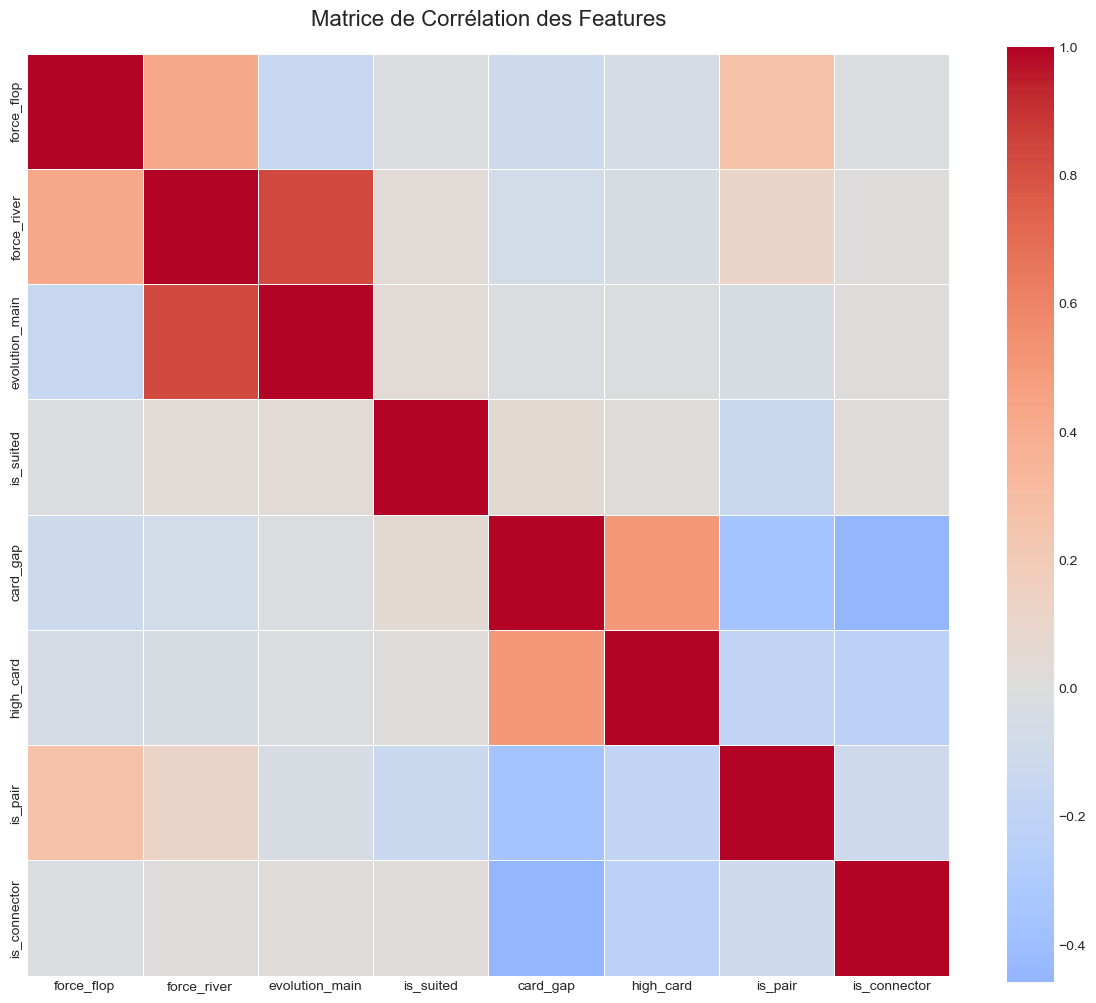


Features stratégiques retenues pour le clustering : 7 sur 7 demandées.

Données normalisées : (1000000, 7)

Moyenne après normalisation (doit être ~0) : 0.000000
Écart-type après normalisation (doit être ~1) : 1.000000


In [4]:
print("\n" + "=" * 60)
print("TRAITEMENT DES DONNÉES")
print("=" * 60)

# Copie du dataframe original
df_processed = df.copy()

# Gestion des valeurs manquantes
print(f"\nValeurs manquantes avant traitement :")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# Stratégie : suppression des lignes avec trop de valeurs manquantes
threshold = 0.5  # Supprimer les lignes avec plus de 50% de valeurs manquantes
df_processed = df_processed.dropna(thresh=len(df_processed.columns) * threshold)

# Pour les colonnes numériques : imputation par la médiane
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Pour les colonnes catégorielles : imputation par le mode
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"\nValeurs manquantes après traitement :")
print(df_processed.isnull().sum().sum())



###################
poker_hand_ranking = {
    'NOTHING': 0, 'PAIR': 1, 'TWO PAIR': 2, 'THREE OF A KIND': 3, 
    'STRAIGHT': 4, 'FLUSH': 5, 'FULL HOUSE': 6, 'FOUR OF A KIND': 7, 
    'STRAIGHT FLUSH': 8, 'ROYAL FLUSH': 9
}

# Assurez-vous que les colonnes 'result' sont bien des chaînes de caractères avant le mapping
df_processed['force_flop'] = df_processed['result1'].astype(str).map(poker_hand_ranking).fillna(0)
df_processed['force_river'] = df_processed['result3'].astype(str).map(poker_hand_ranking).fillna(0)

df_processed['evolution_main'] = df_processed['force_river'] - df_processed['force_flop']

# Exécution de la fonction
print("Extraction des features en cours...")
df_processed = parse_hand_features(df_processed)
print("Terminé.")




####################








# Séparation des colonnes numériques et catégorielles
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"\nColonnes numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nColonnes catégorielles ({len(categorical_features)}) : {categorical_features}")

# Encodage des variables catégorielles
df_encoded = df_processed.copy()
label_encoders = {}


# On exclut les colonnes 'result' car elles ont déjà été encodées de manière ordinale
cols_to_exclude_from_le = [
    'result1', 'result2', 'result3',
    'hand', 'flop', 'turn', 'river' 
]

other_categorical = [col for col in categorical_features 
                     if col not in cols_to_exclude_from_le]

# Encoder les autres colonnes catégorielles normalement
for col in other_categorical:
    le = LabelEncoder()
    # Nous utilisons df_processed[col].astype(str) pour éviter les erreurs de type potentiel
    df_encoded[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"✓ {col} encodé : {len(le.classes_)} classes uniques")

# Matrice de corrélation pour identifier les features importantes
print("\n" + "=" * 60)
print("ANALYSE DE CORRÉLATION")
print("=" * 60)

df_exp = df_encoded.drop(columns=cols_to_exclude_from_le, errors='ignore')
correlation_matrix = df_exp.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation des Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Sélection des features pour le clustering (exclure les colonnes avec variance nulle)
# variance = df_exp.var()
# features_to_keep = variance[variance > 0].index.tolist()
# print(f"\nFeatures retenues après filtrage par variance : {len(features_to_keep)}")

###################
# Sélection des colonnes pertinentes pour l'analyse (VOS FEATURES)
features_intelligentes = [
    'high_card',      # Force brute de la main
    'is_suited',      # Potentiel de couleur
    'is_connector',   # Potentiel de suite
    'is_pair',        # Force immédiate
    'card_gap',       # Facilité à faire des suites
    'force_flop',     # Résultat obtenu au flop
    'evolution_main'  # Potentiel réalisé (River - Flop)
]

# Assurez-vous que toutes ces colonnes existent, sinon elles seront ignorées par .copy()
features_to_keep = [f for f in features_intelligentes if f in df_encoded.columns]
print(f"\nFeatures stratégiques retenues pour le clustering : {len(features_to_keep)} sur {len(features_intelligentes)} demandées.")
###################

df_clustering = df_encoded[features_to_keep].copy()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_keep)

print(f"\nDonnées normalisées : {X_scaled.shape}")
print(f"\nMoyenne après normalisation (doit être ~0) : {X_scaled.mean():.6f}")
print(f"Écart-type après normalisation (doit être ~1) : {X_scaled.std():.6f}")


In [5]:
display(df.head())

,hand,flop,result1,turn,result2,river,result3
0,♣K ♥6,♦Q ♣3 ♥3,PAIR,♦Q ♣3 ♥3 ♣7,PAIR,♦Q ♣3 ♥3 ♣7 ♣6,TWO PAIR
1,♦4 ♦3,♥5 ♣2 ♥6,STRAIGHT,♥5 ♣2 ♥6 ♥A,STRAIGHT,♥5 ♣2 ♥6 ♥A ♠Q,STRAIGHT
2,♥7 ♣5,♥A ♣6 ♥5,PAIR,♥A ♣6 ♥5 ♣7,TWO PAIR,♥A ♣6 ♥5 ♣7 ♣4,TWO PAIR
3,♠2 ♣J,♥10 ♠A ♠9,NOTHING,♥10 ♠A ♠9 ♦4,NOTHING,♥10 ♠A ♠9 ♦4 ♦3,NOTHING
4,♠K ♥9,♥Q ♦K ♦A,PAIR,♥Q ♦K ♦A ♣8,PAIR,♥Q ♦K ♦A ♣8 ♦4,PAIR


In [6]:
display(X_scaled_df.head())

,high_card,is_suited,is_connector,is_pair,card_gap,force_flop,evolution_main
0,0.924738,-0.554669,-0.410795,-0.250301,0.857032,0.498053,0.093499
1,-2.048327,1.802876,2.434303,-0.250301,-1.114885,4.388486,-0.697542
2,-1.057305,-0.554669,-0.410795,-0.250301,-0.786232,0.498053,0.093499
3,0.264057,-0.554669,-0.410795,-0.250301,1.514337,-0.798758,-0.697542
4,0.924738,-0.554669,-0.410795,-0.250301,-0.128927,0.498053,-0.697542


# 2. ANALYSE K-MEANS - DÉTERMINATION DU K OPTIMAL



DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS

 Dataset volumineux détecté (1,000,000 lignes)
   → Utilisation d'un échantillon de 50,000 lignes pour le score de silhouette

Calcul en cours...
k=2 : Inertie=5974719.86, Silhouette=0.2282 (43.3s)
k=3 : Inertie=4841126.01, Silhouette=0.2173 (47.1s)
k=4 : Inertie=3923531.25, Silhouette=0.2104 (40.5s)
k=5 : Inertie=3131258.01, Silhouette=0.2674 (41.7s)
k=6 : Inertie=2991326.20, Silhouette=0.2568 (39.2s)
k=7 : Inertie=2657844.18, Silhouette=0.2749 (42.3s)
k=8 : Inertie=2364378.36, Silhouette=0.2744 (41.1s)
k=9 : Inertie=2249168.15, Silhouette=0.2685 (40.1s)
k=10 : Inertie=2061404.49, Silhouette=0.2722 (40.8s)


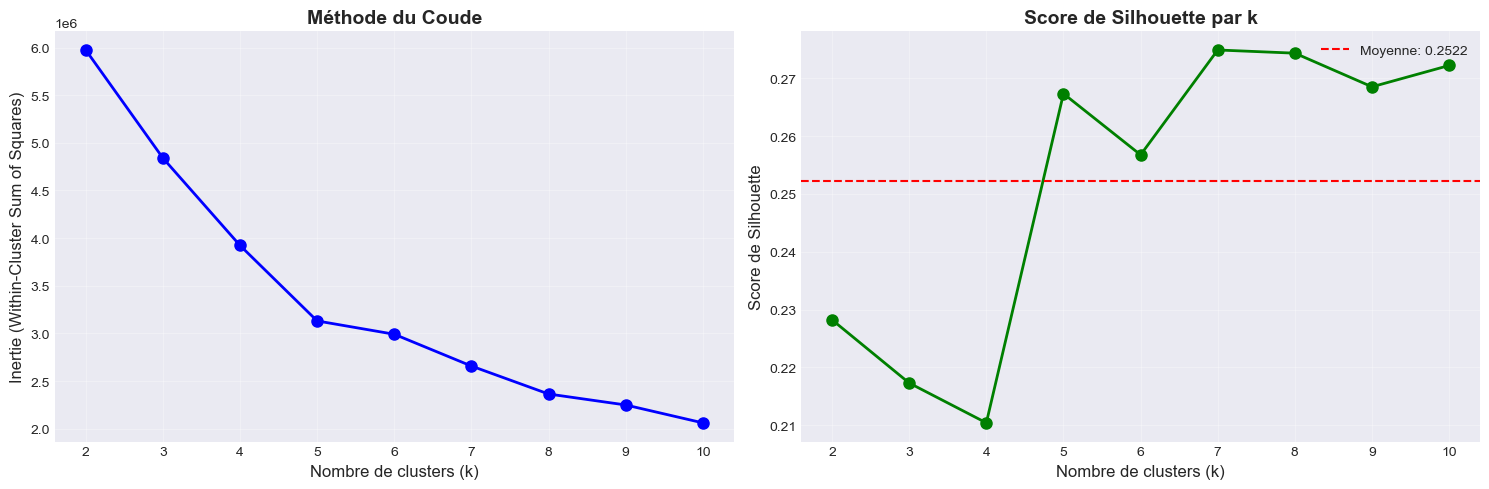


✓ K optimal suggéré (silhouette maximale) : 7
  Score de silhouette : 0.2749

✓ K suggéré (méthode du coude) : 5


In [7]:
print("\n" + "=" * 60)
print("DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS")
print("=" * 60)

# Pour les gros datasets : échantillonnage pour la silhouette
n_samples = len(X_scaled)
use_sampling = n_samples > 100000  # Échantillonner si plus de 100k lignes

if use_sampling:
    sample_size = 50000  # Échantillon de 50k pour silhouette
    sample_indices = np.random.choice(n_samples, size=sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"\n Dataset volumineux détecté ({n_samples:,} lignes)")
    print(f"   → Utilisation d'un échantillon de {sample_size:,} lignes pour le score de silhouette")
else:
    X_sample = X_scaled
    sample_indices = None

# Plage de k à tester
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\nCalcul en cours...")
import time
for k in k_range:
    start_time = time.time()
    
    # KMeans avec mini-batch pour gros datasets
    if n_samples > 50000:
        from sklearn.cluster import MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=3)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
    # Silhouette sur échantillon si dataset trop gros
    if use_sampling:
        labels_sample = kmeans.predict(X_sample)
        sil_score = silhouette_score(X_sample, labels_sample)
    else:
        sil_score = silhouette_score(X_scaled, kmeans.labels_)
    
    silhouette_scores.append(sil_score)
    
    elapsed = time.time() - start_time
    print(f"k={k} : Inertie={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f} ({elapsed:.1f}s)")

# Visualisation : Méthode du coude et Score de Silhouette
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Méthode du coude
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertie (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Méthode du Coude', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Score de Silhouette
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[1].set_ylabel('Score de Silhouette', fontsize=12)
axes[1].set_title('Score de Silhouette par k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=np.mean(silhouette_scores), color='r', linestyle='--', 
                label=f'Moyenne: {np.mean(silhouette_scores):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Suggestion du k optimal
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ K optimal suggéré (silhouette maximale) : {best_k_silhouette}")
print(f"  Score de silhouette : {max(silhouette_scores):.4f}")

# Calcul de la dérivée seconde pour la méthode du coude
derivatives = np.diff(inertias, 2)
elbow_k = k_range[np.argmax(derivatives) + 1] if len(derivatives) > 0 else best_k_silhouette
print(f"\n✓ K suggéré (méthode du coude) : {elbow_k}")


# 3. APPLICATION DU K-MEANS AVEC K OPTIMAL


In [10]:
print("\n" + "=" * 60)
print(f"CLUSTERING AVEC K={best_k_silhouette}")
print("=" * 60)

# K-Means final avec optimisation pour gros datasets
#optimal_k = best_k_silhouette  # Vous pouvez modifier cette valeur manuellement
optimal_k = 7

if n_samples > 50000:
    print("\n⚡ Utilisation de MiniBatchKMeans pour optimiser les performances...")
    from sklearn.cluster import MiniBatchKMeans
    kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1024, n_init=3)
else:
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

print("Clustering en cours...")
clusters = kmeans_final.fit_predict(X_scaled)
print("✓ Clustering terminé !")

# Ajout des clusters au dataframe
df_processed['Cluster'] = clusters
df_encoded['Cluster'] = clusters

# Statistiques par cluster
print(f"\nDistribution des clusters :")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print(cluster_counts)

print(f"\nPourcentage par cluster :")
print((cluster_counts / len(clusters) * 100).round(2))

# Score de silhouette final - RÉUTILISATION du score déjà calculé
print("\n" + "=" * 60)
print("SCORE DE SILHOUETTE")
print("=" * 60)

# On réutilise simplement le score déjà calculé pendant la recherche du k optimal !
if optimal_k in range(2, 11):
    final_silhouette = silhouette_scores[optimal_k - 2]  # -2 car range commence à 2
    print(f"✓ Score de silhouette (k={optimal_k}) : {final_silhouette:.4f}")
    print(f"  (Réutilisé du calcul précédent - pas de recalcul nécessaire)")
else:
    print("⚠️  Score de silhouette non disponible (k hors de la plage testée)")


CLUSTERING AVEC K=7

⚡ Utilisation de MiniBatchKMeans pour optimiser les performances...
Clustering en cours...
✓ Clustering terminé !

Distribution des clusters :
0    301586
1    141679
2     31446
3     74842
4    176038
5    246888
6     27521
Name: count, dtype: int64

Pourcentage par cluster :
0    30.16
1    14.17
2     3.14
3     7.48
4    17.60
5    24.69
6     2.75
Name: count, dtype: float64

SCORE DE SILHOUETTE
✓ Score de silhouette (k=7) : 0.2749
  (Réutilisé du calcul précédent - pas de recalcul nécessaire)


# 4. RÉDUCTION DE DIMENSION ET VISUALISATION



RÉDUCTION DE DIMENSION - PCA (OPTIMISÉ)

Réduction PCA en cours...
Variance expliquée par PC1 : 27.79%
Variance expliquée par PC2 : 19.12%
Variance totale expliquée : 46.91%

⚡ Optimisation : Utilisation d'un échantillon de 50000 points pour les graphiques.
Génération des graphiques...
Calcul du score de silhouette (sur échantillon)...


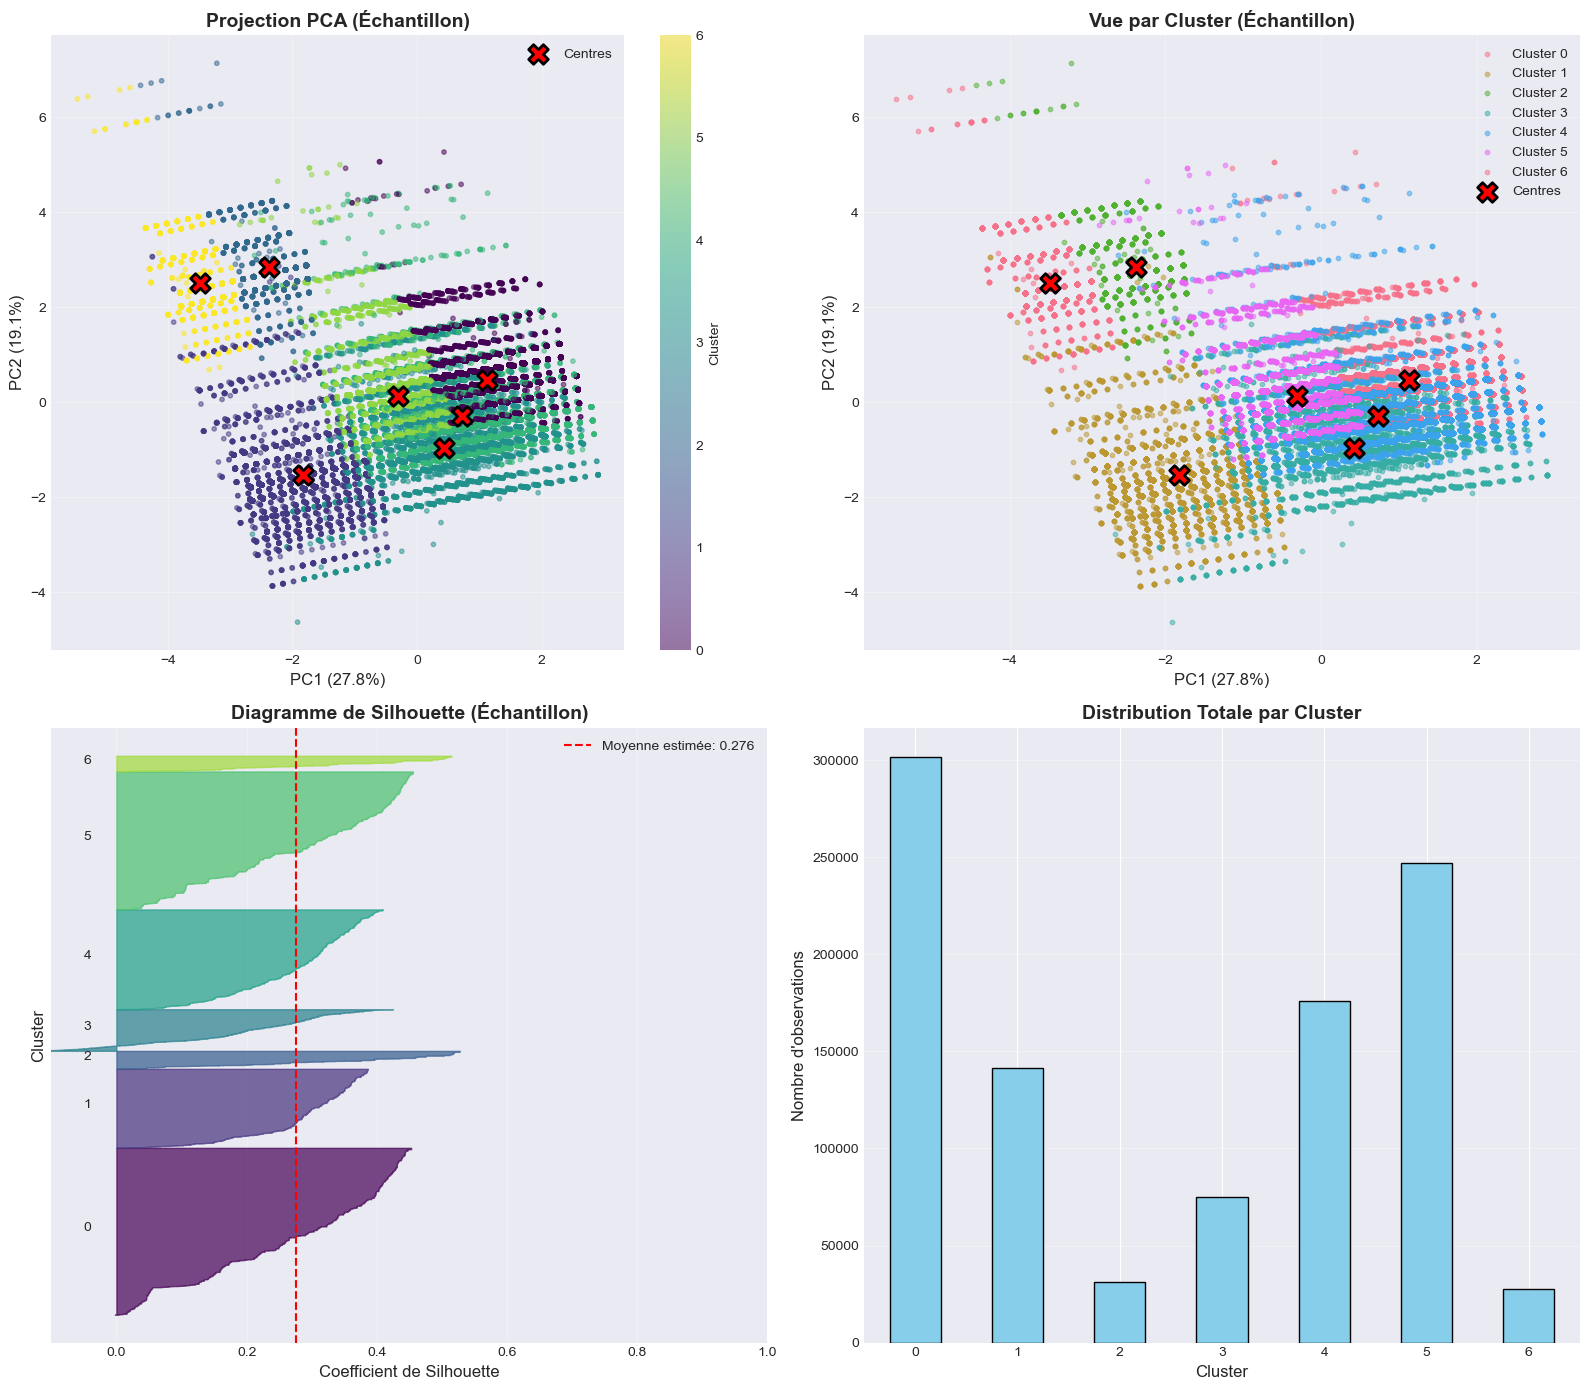

In [11]:
print("\n" + "=" * 60)
print("RÉDUCTION DE DIMENSION - PCA (OPTIMISÉ)")
print("=" * 60)

# 1. PCA sur l'ensemble des données (Ceci est rapide et doit rester sur tout le dataset)
print("\nRéduction PCA en cours...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

print(f"Variance expliquée par PC1 : {explained_variance[0]:.2%}")
print(f"Variance expliquée par PC2 : {explained_variance[1]:.2%}")
print(f"Variance totale expliquée : {sum(explained_variance):.2%}")

# Projection des centres (très rapide)
centers_pca = pca.transform(kmeans_final.cluster_centers_)

# ==============================================================================
# OPTIMISATION : Échantillonnage pour la visualisation et la silhouette
# ==============================================================================
# On prend 50 000 points au hasard pour les graphiques.
# C'est suffisant pour voir la structure sans tuer le processeur.
n_samples_visu = 50000 

if len(X_scaled) > n_samples_visu:
    print(f"\n⚡ Optimisation : Utilisation d'un échantillon de {n_samples_visu} points pour les graphiques.")
    # Indices aléatoires
    indices = np.random.choice(len(X_scaled), n_samples_visu, replace=False)
    
    # Création des sous-ensembles
    X_pca_visu = X_pca[indices]
    X_scaled_visu = X_scaled[indices]
    clusters_visu = clusters[indices]
else:
    X_pca_visu = X_pca
    X_scaled_visu = X_scaled
    clusters_visu = clusters

# ==============================================================================
# Visualisations
# ==============================================================================
print("Génération des graphiques...")
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA avec clusters (Sur l'échantillon)
# Note : j'ai retiré 'edgecolors' qui ralentit énormément le rendu
scatter1 = axes[0, 0].scatter(X_pca_visu[:, 0], X_pca_visu[:, 1], c=clusters_visu, 
                              cmap='viridis', alpha=0.5, s=10) # Taille réduite (s=10) pour lisibilité
axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centres')
axes[0, 0].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 0].set_title('Projection PCA (Échantillon)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# 2. PCA avec densité par cluster (Sur l'échantillon)
for i in range(optimal_k):
    cluster_data = X_pca_visu[clusters_visu == i]
    axes[0, 1].scatter(cluster_data[:, 0], cluster_data[:, 1], 
                       label=f'Cluster {i}', alpha=0.5, s=10)

axes[0, 1].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centres', zorder=5)
axes[0, 1].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 1].set_title('Vue par Cluster (Échantillon)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Diagramme de silhouette (Calculé sur l'échantillon uniquement !)
print("Calcul du score de silhouette (sur échantillon)...")
silhouette_vals = silhouette_samples(X_scaled_visu, clusters_visu)
y_lower = 10

# Calcul du score moyen sur l'échantillon pour la ligne rouge
silhouette_avg_sample = np.mean(silhouette_vals)

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters_visu == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    axes[1, 0].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1, 0].set_xlabel('Coefficient de Silhouette', fontsize=12)
axes[1, 0].set_ylabel('Cluster', fontsize=12)
axes[1, 0].set_title('Diagramme de Silhouette (Échantillon)', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=silhouette_avg_sample, color='red', linestyle='--', 
                   label=f'Moyenne estimée: {silhouette_avg_sample:.3f}')
axes[1, 0].legend()
axes[1, 0].set_xlim([-0.1, 1])
axes[1, 0].set_yticks([])
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution des clusters (Sur TOUT le dataset, car c'est rapide)
# On reprend 'clusters' (le complet) et non 'clusters_visu'
cluster_counts = pd.Series(clusters).value_counts().sort_index()
cluster_counts.plot(kind='bar', ax=axes[1, 1], color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Nombre d\'observations', fontsize=12)
axes[1, 1].set_title('Distribution Totale par Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [ ]:

print("\n" + "=" * 60)
print("RÉDUCTION DE DIMENSION - PCA")
print("=" * 60)

# PCA
print("\nRéduction PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

print(f"Variance expliquée par PC1 : {explained_variance[0]:.2%}")
print(f"Variance expliquée par PC2 : {explained_variance[1]:.2%}")
print(f"Variance totale expliquée : {sum(explained_variance):.2%}")

# Projection des centres de clusters dans l'espace PCA
centers_pca = pca.transform(kmeans_final.cluster_centers_)

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA avec clusters
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                               cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centres')
axes[0, 0].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 0].set_title('Clustering - Projection PCA', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# 2. PCA avec densité par cluster
for i in range(optimal_k):
    cluster_data = X_pca[clusters == i]
    axes[0, 1].scatter(cluster_data[:, 0], cluster_data[:, 1], 
                       label=f'Cluster {i}', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

axes[0, 1].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centres', zorder=5)
axes[0, 1].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 1].set_title('Clustering PCA - Vue par Cluster', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Diagramme de silhouette
silhouette_vals = silhouette_samples(X_scaled, clusters)
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    axes[1, 0].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1, 0].set_xlabel('Coefficient de Silhouette', fontsize=12)
axes[1, 0].set_ylabel('Cluster', fontsize=12)
axes[1, 0].set_title('Diagramme de Silhouette', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=final_silhouette, color='red', linestyle='--', 
                   label=f'Score moyen: {final_silhouette:.3f}')
axes[1, 0].legend()
axes[1, 0].set_xlim([-0.1, 1])
axes[1, 0].set_yticks([])
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution des clusters
cluster_counts.plot(kind='bar', ax=axes[1, 1], color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Nombre d\'observations', fontsize=12)
axes[1, 1].set_title('Distribution des Observations par Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


RÉDUCTION DE DIMENSION - PCA

Réduction PCA...
Variance expliquée par PC1 : 27.79%
Variance expliquée par PC2 : 19.12%
Variance totale expliquée : 46.91%


KeyboardInterrupt: 

# 5. ANALYSE ET INTERPRÉTATION DES CLUSTERS



CARACTÉRISTIQUES DES CLUSTERS

Moyennes des features numériques par cluster :


,force_flop,force_river,evolution_main,is_suited,card_gap,high_card,is_pair,is_connector
Cluster,,,,,,,,
0,0.531444,1.091831,0.560387,0.000000,7.021039,12.480158,0.000000,0.000000
1,0.593546,1.465397,0.871851,0.248287,1.000000,8.474806,0.000000,1.000000
2,1.445430,2.096069,0.650639,0.000032,0.000572,11.069357,0.999746,0.000000
3,0.593277,4.762607,4.169330,0.321451,4.771973,10.466155,0.000013,0.036183
4,0.595621,1.149519,0.553897,1.000000,5.393864,10.705405,0.000000,0.000000
5,0.555065,1.116591,0.561526,0.000000,3.347546,8.483442,0.000000,0.000000
6,1.447077,2.196795,0.749718,0.000000,0.000218,4.567276,0.999891,0.000000


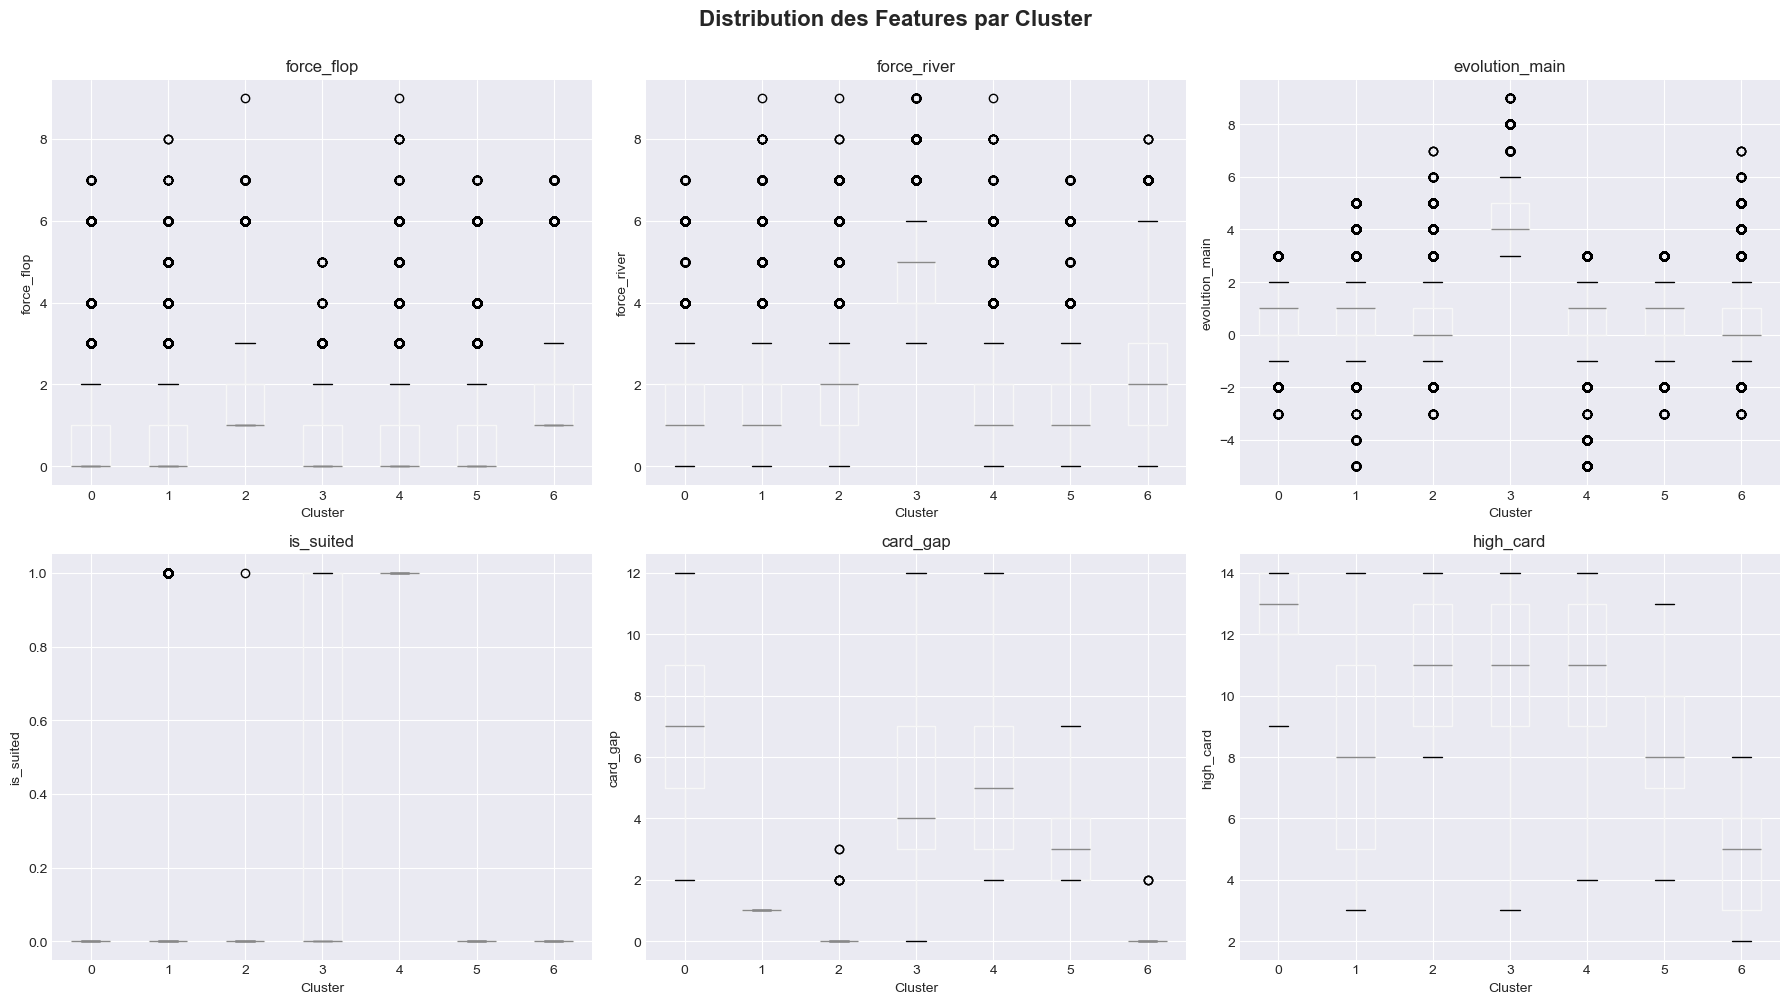

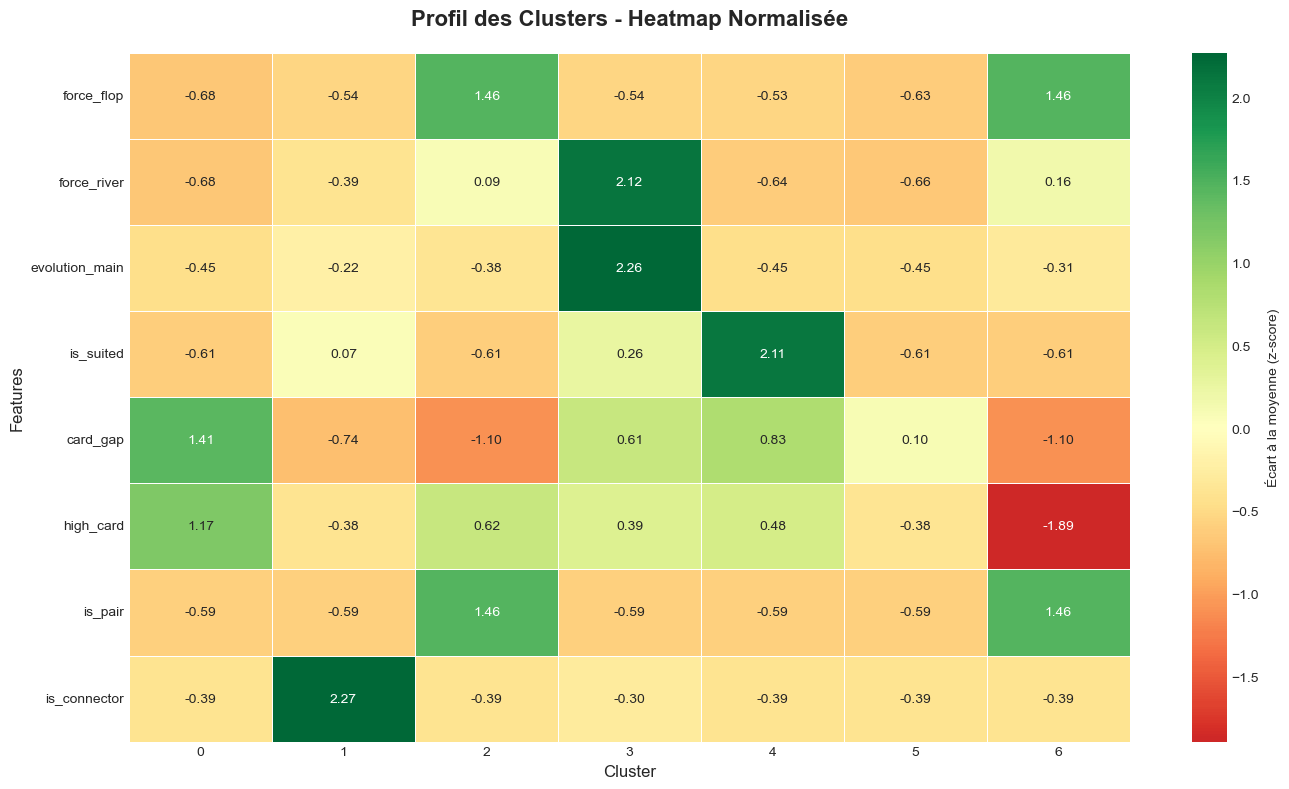


EXPORT DES RÉSULTATS

✓ Résultats sauvegardés dans : resultats_clustering.csv

RÉSUMÉ DE L'ANALYSE

• Dataset : 1000000 observations, 7 features
• Features utilisées pour le clustering : 7
• Nombre optimal de clusters : 7
• Score de silhouette : 0.2749
• Variance expliquée par PCA (2D) : 46.91%

ANALYSE TERMINÉE !


In [12]:
print("\n" + "=" * 60)
print("CARACTÉRISTIQUES DES CLUSTERS")
print("=" * 60)

# Statistiques par cluster pour les features numériques
cluster_stats = df_processed.groupby('Cluster')[numeric_features].mean()

print("\nMoyennes des features numériques par cluster :")
display(cluster_stats)

# Visualisation des caractéristiques principales
if len(numeric_features) > 0:
    n_features_to_plot = min(6, len(numeric_features))
    features_to_plot = numeric_features[:n_features_to_plot]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features_to_plot):
        if idx < len(axes):
            df_processed.boxplot(column=feature, by='Cluster', ax=axes[idx])
            axes[idx].set_title(f'{feature}')
            axes[idx].set_xlabel('Cluster')
            axes[idx].set_ylabel(feature)
            plt.sca(axes[idx])
            plt.xticks(rotation=0)
    
    # Supprimer les sous-graphiques vides
    for idx in range(len(features_to_plot), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle('Distribution des Features par Cluster', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Heatmap des moyennes normalisées par cluster
cluster_stats_normalized = (cluster_stats - cluster_stats.mean()) / cluster_stats.std()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_stats_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, linewidths=0.5, cbar_kws={'label': 'Écart à la moyenne (z-score)'})
plt.title('Profil des Clusters - Heatmap Normalisée', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Export des résultats
print("\n" + "=" * 60)
print("EXPORT DES RÉSULTATS")
print("=" * 60)

# Sauvegarde du dataframe avec les clusters
output_file = 'resultats_clustering.csv'
df_processed.to_csv(output_file, index=False)
print(f"\n✓ Résultats sauvegardés dans : {output_file}")

# Résumé final
print("\n" + "=" * 60)
print("RÉSUMÉ DE L'ANALYSE")
print("=" * 60)
print(f"\n• Dataset : {df.shape[0]} observations, {df.shape[1]} features")
print(f"• Features utilisées pour le clustering : {len(features_to_keep)}")
print(f"• Nombre optimal de clusters : {optimal_k}")
print(f"• Score de silhouette : {final_silhouette:.4f}")
print(f"• Variance expliquée par PCA (2D) : {sum(explained_variance):.2%}")
print("\n" + "=" * 60)
print("ANALYSE TERMINÉE !")
print("=" * 60)
